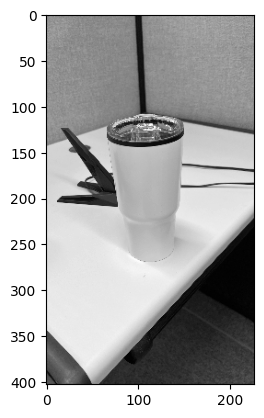

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

filepath = os.getcwd()

image1 = cv2.imread("./sample1.jpg", cv2.IMREAD_GRAYSCALE)
image1 = cv2.resize(image1, dsize=(0,0), fx=0.1, fy=0.1)
image1 = np.float32(image1)
plt.imshow(image1, cmap="gray")
plt.show()

In [2]:
print(image1)

[[129. 137. 140. ... 165. 173. 144.]
 [158. 152. 134. ... 167. 158. 158.]
 [132. 141. 129. ... 129. 158. 157.]
 ...
 [ 86.  85.  85. ...  69.  62.  77.]
 [ 84.  86.  84. ...  72.  76.  77.]
 [ 84.  86.  84. ...  72.  78.  71.]]


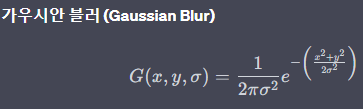

In [3]:
def GaussianKernel(size, sigma):
    arr = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(arr, arr)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma ** 2)) 
    kernel /= kernel.sum()
    return np.array(kernel)

In [4]:
kernel = GaussianKernel(5, 1)
print(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


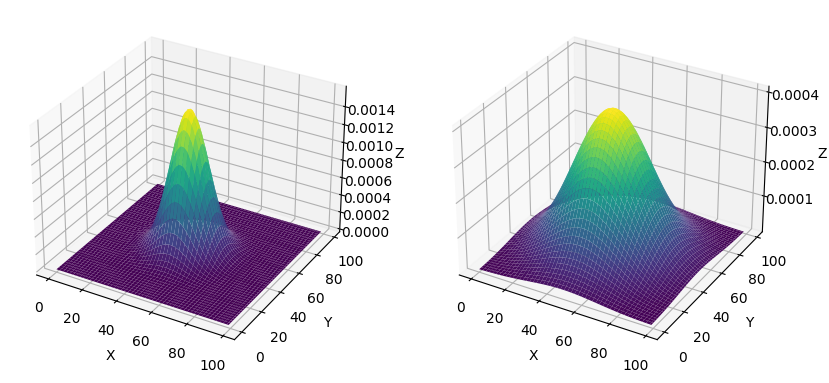

In [5]:
kernel_plot1 = GaussianKernel(100, 10)
kernel_plot2 = GaussianKernel(100, 20)

# x, y, z 좌표 생성
x = np.linspace(0, kernel_plot1.shape[1]-1, kernel_plot1.shape[1])
y = np.linspace(0, kernel_plot1.shape[0]-1, kernel_plot1.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x, y, kernel_plot1, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x, y, kernel_plot2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [6]:
def convolve2d(image, kernel):
    image_height, image_width = image.shape[0], image.shape[1]
    kernel_height, kernel_width = kernel.shape[0], kernel.shape[1]

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    output = np.zeros_like(image)
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
    
    for x in range(image_height):
        for y in range(image_width):
            region = padded_image[x:x+kernel_height, y:y+kernel_width]
            output[x, y] = np.sum(region * kernel)
    
    return output


def gaussian_filter(image, kernel_size, sigma):
    kernel = GaussianKernel(kernel_size, sigma)
    filter = convolve2d(image, kernel)
    return filter

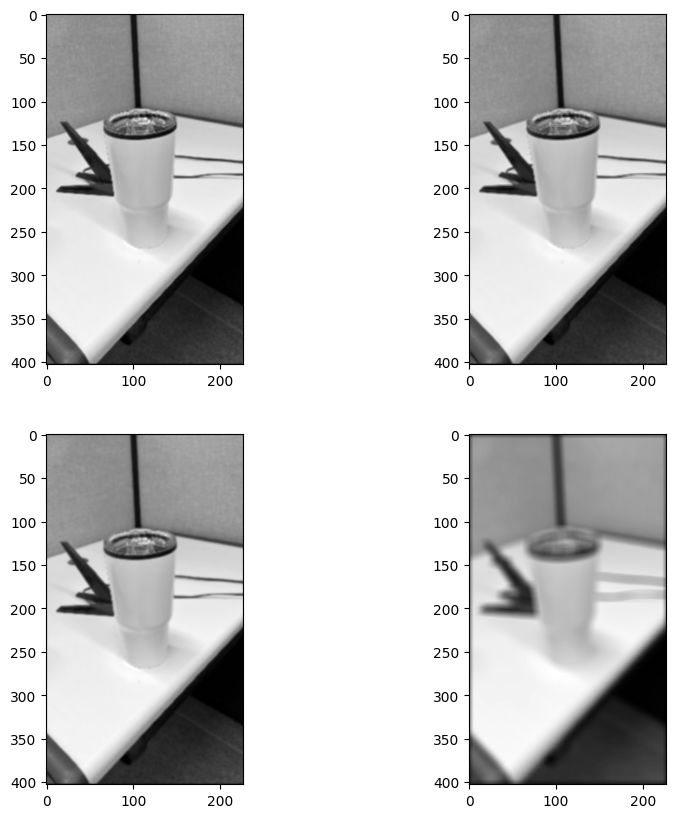

In [7]:
blurred_image1 = gaussian_filter(image1, kernel_size=3, sigma=1)
blurred_image2 = gaussian_filter(image1, kernel_size=3, sigma=10)
blurred_image3 = gaussian_filter(image1, kernel_size=11, sigma=1)
blurred_image4 = gaussian_filter(image1, kernel_size=11, sigma=10)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(blurred_image1, cmap="gray")

plt.subplot(2,2,2)
plt.imshow(blurred_image2, cmap="gray")

plt.subplot(2,2,3)
plt.imshow(blurred_image3, cmap="gray")

plt.subplot(2,2,4)
plt.imshow(blurred_image4, cmap="gray")

plt.show()

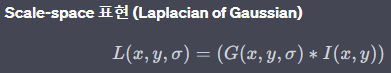  
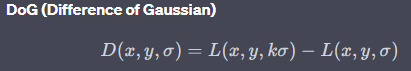

In [8]:
def build_gaussian_pyramid(image, num_octaves, num_scales, sigma, kernel_size = 3):
    
    pyramids = []
    for octave in range(int(num_octaves)):
        scales = []
        for scale in range(int(num_scales)):
            size = 2 ** octave
            k = 2 ** (scale / num_scales)
            sigma_ = sigma * k
            blurred = gaussian_filter(image, kernel_size=kernel_size, sigma=sigma_)
            resized = cv2.resize(blurred, (image.shape[1] // size, image.shape[0] // size), interpolation=cv2.INTER_LINEAR)
            scales.append(resized)
        pyramids.append(scales)
    return pyramids


def compute_DoG(pyramids):
    DoGs = []
    for octave in pyramids:
        DoG = []
        for i in range(1, len(octave)):
            DoG.append(octave[i] - octave[i-1])
        DoGs.append(DoG)
    return DoGs

In [9]:
pyramid = build_gaussian_pyramid(image1, 4., 5., 1.)
print(len(pyramid))
print(len(pyramid[0]))
print(len(pyramid[0][0]))
print(len(pyramid[0][0][0]))

4
5
403
227


In [10]:
print(len(pyramid[1][0]))
print(len(pyramid[1][0][0]))
print(len(pyramid[2][0]))
print(len(pyramid[2][0][0]))
print(len(pyramid[3][0]))
print(len(pyramid[3][0][0]))

201
113
100
56
50
28


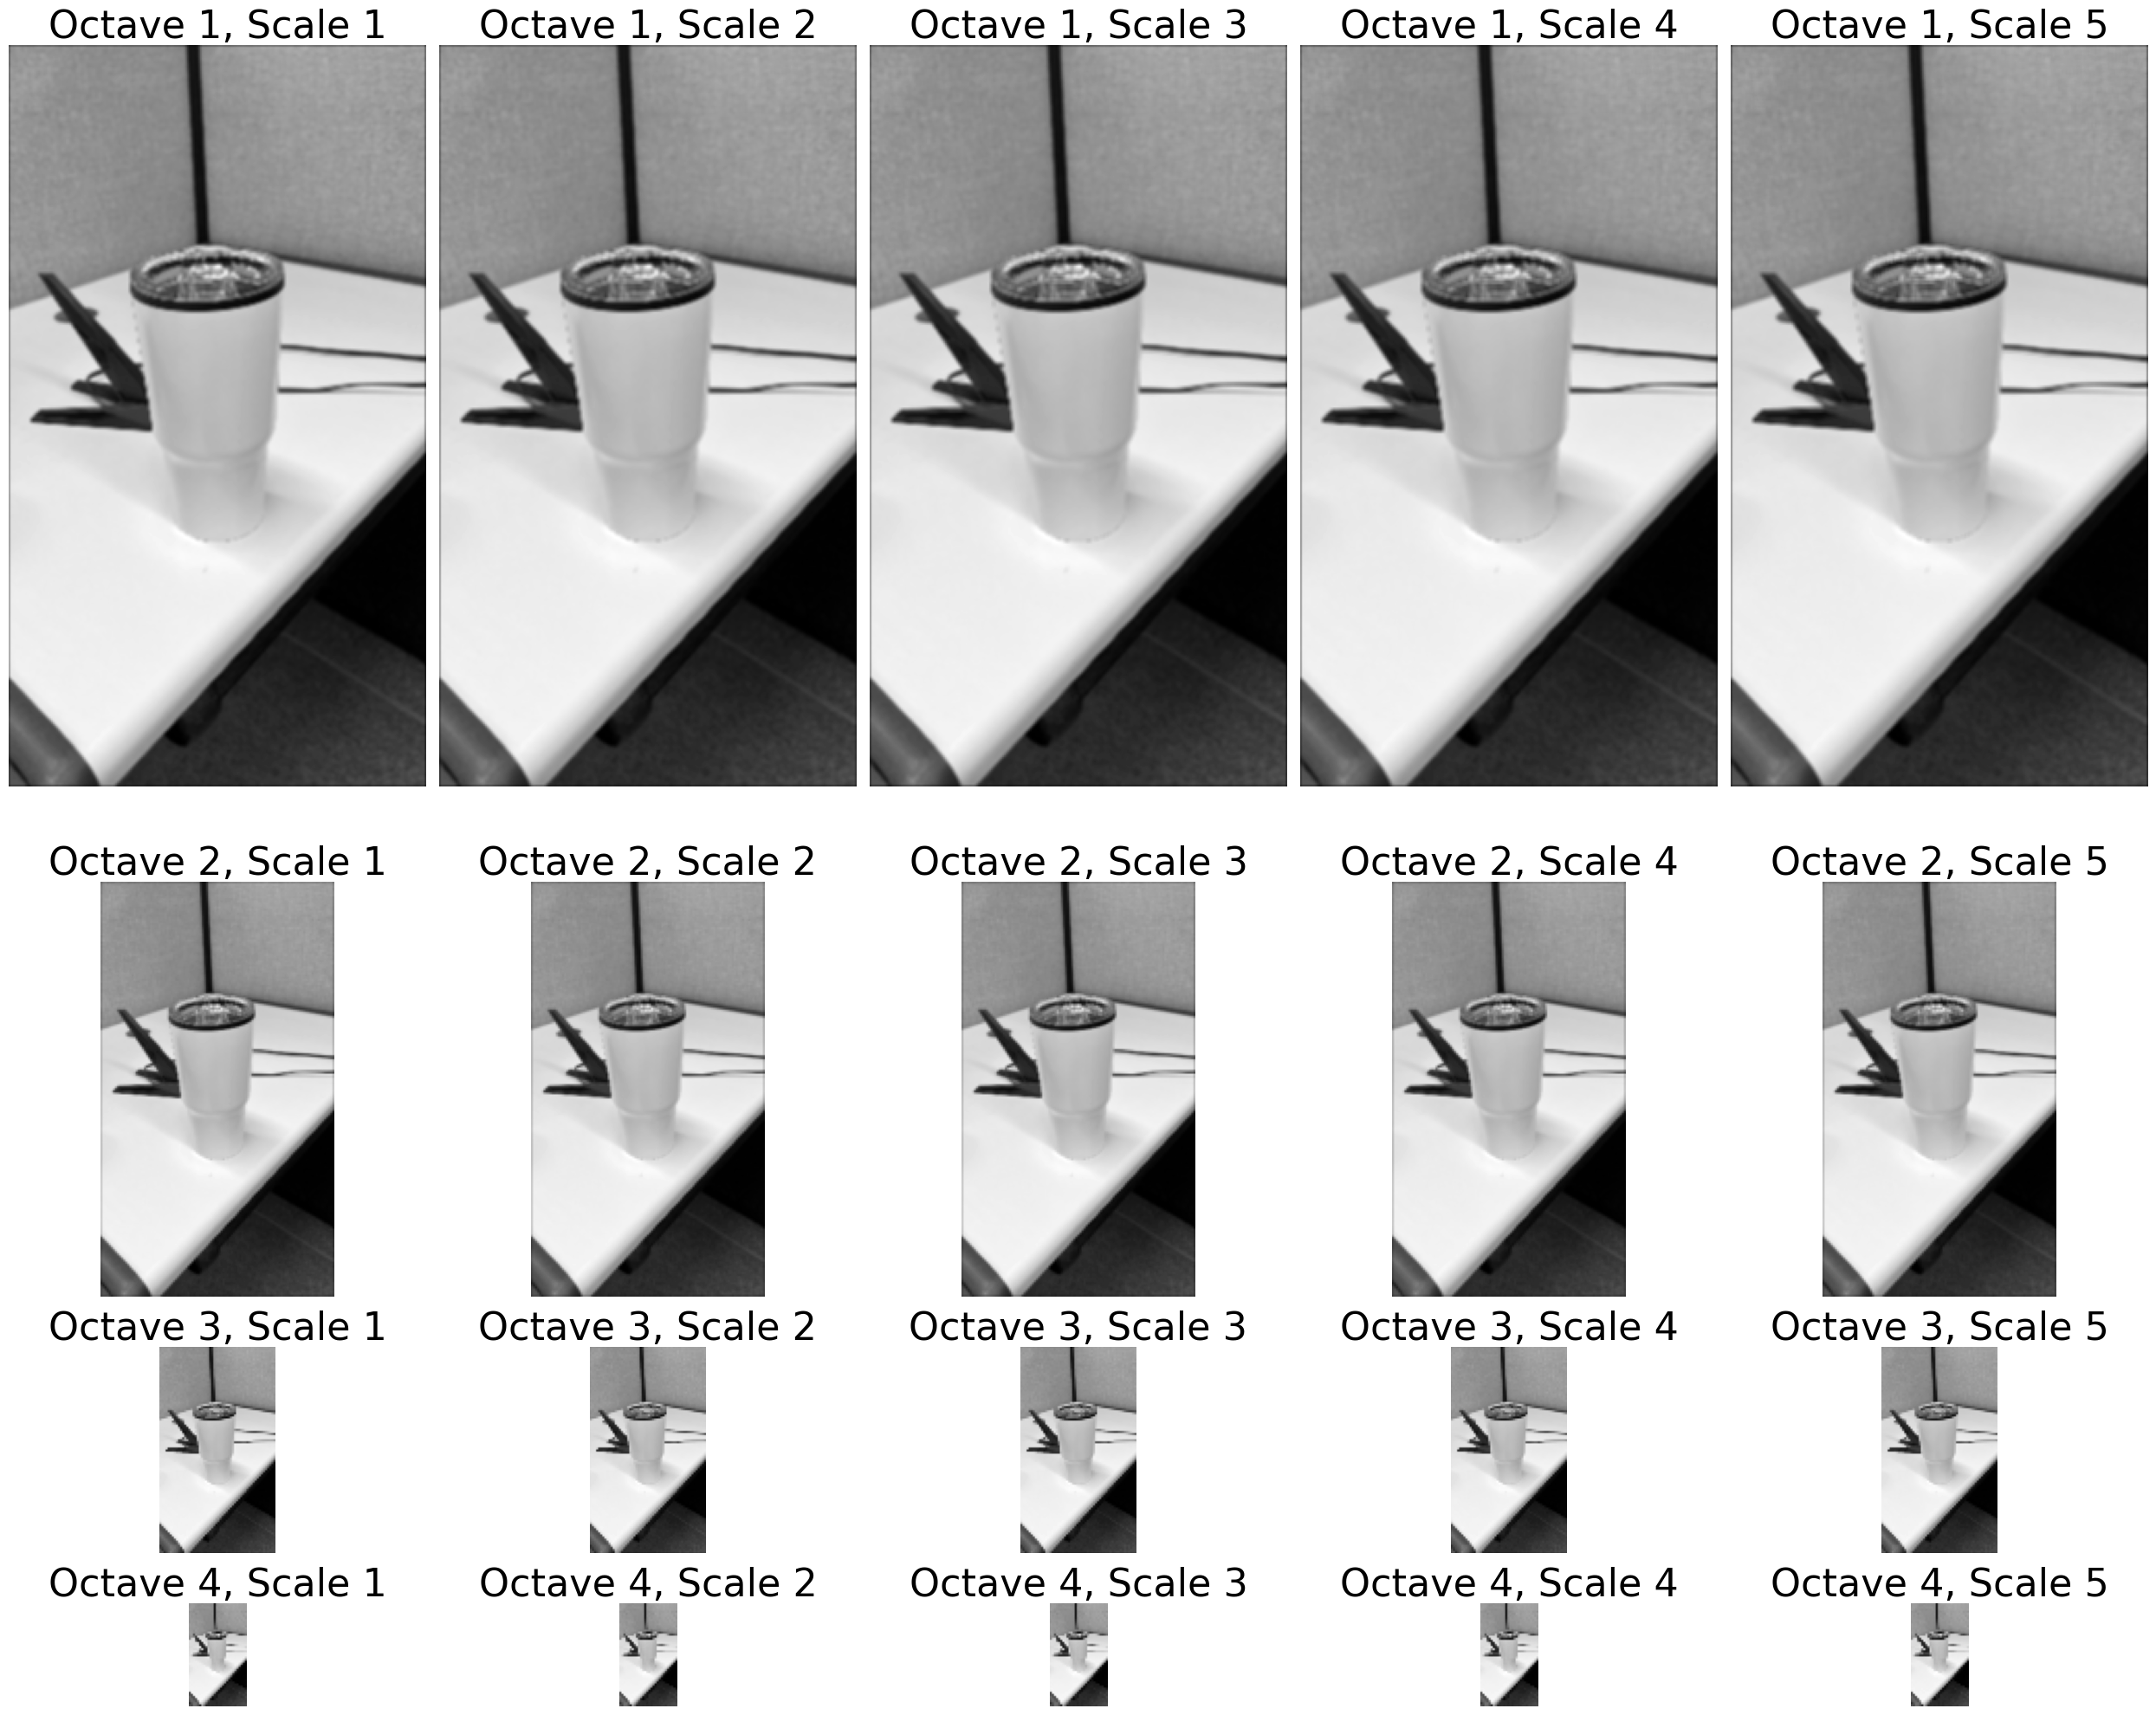

In [11]:
from matplotlib import gridspec

def visualize_pyramid(pyramids):
    num_octaves = len(pyramids)
    num_scales = len(pyramids[0])
    
    # 각 옥타브의 첫 번째 이미지의 높이를 기반으로 행의 높이 비율을 설정합니다.
    heights = [len(pyramids[i][0]) for i in range(num_octaves)]
    total_height = sum(heights)
    height_ratios = [h / total_height for h in heights]
    
    # gridspec을 사용하여 다른 높이 비율을 갖는 서브플롯을 생성합니다.
    gs = gridspec.GridSpec(num_octaves, num_scales, height_ratios=height_ratios)
    fig = plt.figure(figsize=(num_scales * 5, num_octaves * 5))
    
    for i in range(num_octaves):
        for j in range(num_scales):
            ax = fig.add_subplot(gs[i, j])
            ax.imshow(pyramids[i][j], cmap='gray')
            ax.axis('off')
            ax.set_title(f'Octave {i+1}, Scale {j+1}', fontsize=32)
    
    plt.tight_layout()
    plt.show()


visualize_pyramid(pyramid)

In [12]:
DoG = compute_DoG(pyramid)

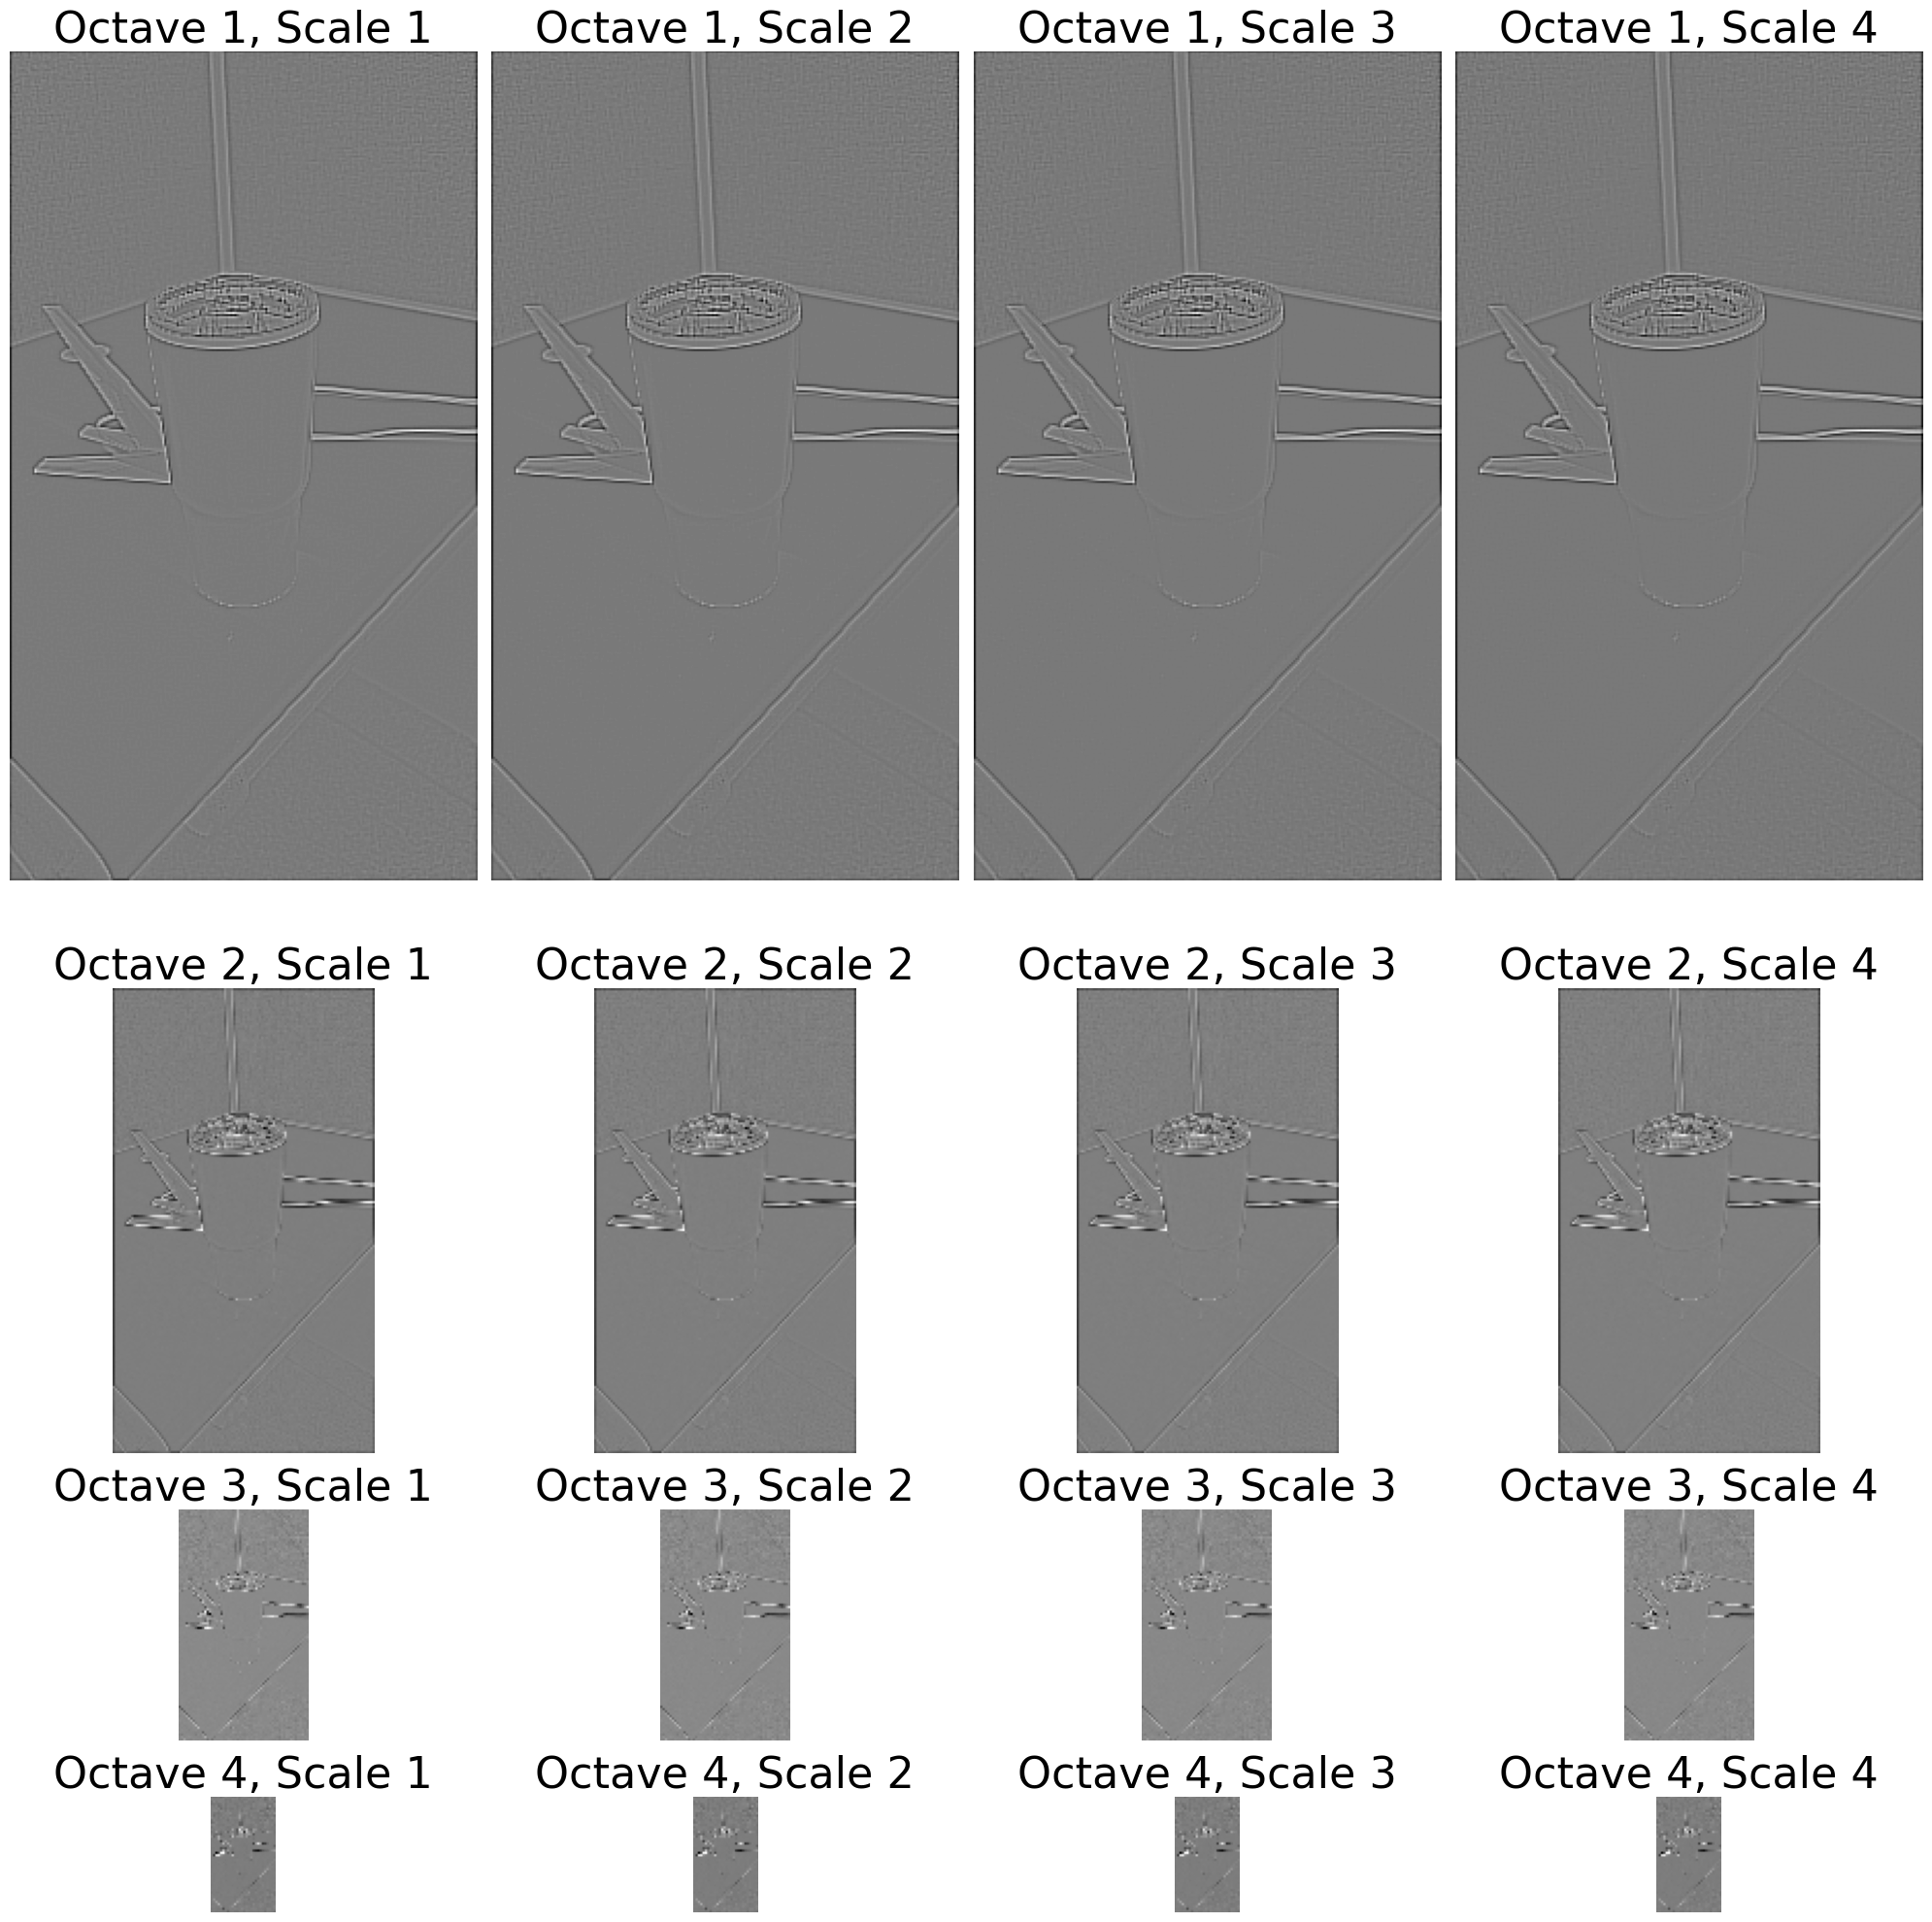

In [13]:
visualize_pyramid(DoG)

In [14]:
print(DoG)

[[array([[-2.6365356 , -1.9076233 , -1.8702164 , ..., -2.5582123 ,
        -2.6541824 , -3.044159  ],
       [-2.5564651 , -0.5825348 ,  0.20343018, ..., -0.14826965,
        -0.35520935, -2.1985092 ],
       [-1.7477264 , -0.01202393,  0.62994385, ...,  0.7370453 ,
         0.04516602, -2.3346405 ],
       ...,
       [-1.2869301 , -0.00375366,  0.02052307, ...,  0.19655609,
         0.3280487 , -1.1023827 ],
       [-1.2330055 , -0.03253174,  0.00738525, ..., -0.10421753,
        -0.09759521, -1.2506447 ],
       [-1.7841339 , -1.3064461 , -1.2171135 , ..., -1.1148949 ,
        -1.1918411 , -1.5014992 ]], dtype=float32), array([[-1.9437714 , -1.4232407 , -1.3884125 , ..., -1.9139328 ,
        -1.9554825 , -2.2494965 ],
       [-1.8823166 , -0.43501282,  0.13873291, ..., -0.08747864,
        -0.2894287 , -1.6266174 ],
       [-1.3097687 , -0.00578308,  0.46894836, ...,  0.51763916,
         0.0521698 , -1.7379532 ],
       ...,
       [-0.9594765 , -0.00395203,  0.01702881, ...,  0.15

In [15]:
def find_keypoints(DoGs, threshold=1):
    keypoints = []
    for o, octave in enumerate(DoGs):
        for s, scale in enumerate(octave):
            height, width = scale.shape
            for i in range(8, height - 8):  # 경계 부분을 무시하도록 범위를 조정
                for j in range(8, width - 8):  # 경계 부분을 무시하도록 범위를 조정
                    patch = scale[i-1:i+2, j-1:j+2]
                    pixel = scale[i, j]
                    
                    # 그래디언트의 크기에 대한 임계값을 적용
                    if np.abs(pixel) < threshold:
                        continue
                    
                    if pixel == np.max(patch) or pixel == np.min(patch):
                        keypoints.append((i, j, o, s))
    return keypoints


In [16]:
keypoints = find_keypoints(DoG)
keypoints

[(11, 103, 0, 0),
 (13, 103, 0, 0),
 (15, 103, 0, 0),
 (22, 105, 0, 0),
 (29, 104, 0, 0),
 (30, 105, 0, 0),
 (31, 104, 0, 0),
 (36, 104, 0, 0),
 (43, 106, 0, 0),
 (50, 105, 0, 0),
 (56, 105, 0, 0),
 (69, 106, 0, 0),
 (71, 106, 0, 0),
 (73, 106, 0, 0),
 (93, 107, 0, 0),
 (95, 107, 0, 0),
 (108, 103, 0, 0),
 (108, 105, 0, 0),
 (108, 108, 0, 0),
 (108, 114, 0, 0),
 (108, 116, 0, 0),
 (109, 99, 0, 0),
 (109, 104, 0, 0),
 (109, 109, 0, 0),
 (109, 112, 0, 0),
 (109, 115, 0, 0),
 (109, 117, 0, 0),
 (109, 119, 0, 0),
 (110, 96, 0, 0),
 (110, 98, 0, 0),
 (110, 100, 0, 0),
 (110, 119, 0, 0),
 (110, 126, 0, 0),
 (110, 128, 0, 0),
 (111, 96, 0, 0),
 (111, 102, 0, 0),
 (111, 108, 0, 0),
 (111, 110, 0, 0),
 (111, 112, 0, 0),
 (111, 117, 0, 0),
 (111, 134, 0, 0),
 (112, 93, 0, 0),
 (112, 95, 0, 0),
 (112, 98, 0, 0),
 (112, 100, 0, 0),
 (112, 103, 0, 0),
 (112, 109, 0, 0),
 (112, 111, 0, 0),
 (112, 114, 0, 0),
 (112, 116, 0, 0),
 (112, 120, 0, 0),
 (112, 125, 0, 0),
 (112, 127, 0, 0),
 (112, 131, 0, 0

In [17]:
def visualize_keypoints(pyramids, keypoints):
    num_octaves = len(pyramids)
    num_scales = len(pyramids[0])

    # 각 옥타브의 첫 번째 이미지의 높이를 기반으로 행의 높이 비율을 설정합니다.
    heights = [len(pyramids[i][0]) for i in range(num_octaves)]
    total_height = sum(heights)
    height_ratios = [h / total_height for h in heights]

    # gridspec을 사용하여 다른 높이 비율을 갖는 서브플롯을 생성합니다.
    gs = gridspec.GridSpec(num_octaves, num_scales, height_ratios=height_ratios)
    fig = plt.figure(figsize=(num_scales * 5, num_octaves * 5))

    for i in range(num_octaves):
        for j in range(num_scales):
            ax = fig.add_subplot(gs[i, j])
            ax.imshow(pyramids[i][j], cmap='gray')
            ax.axis('off')
            ax.set_title(f'Octave {i+1}, Scale {j+1}', fontsize=32)

            # 해당 옥타브와 스케일의 키 포인트를 찾아 표시합니다.
            for keypoint in keypoints:
                if keypoint[2] == i and keypoint[3] == j:
                    ax.plot(keypoint[1], keypoint[0], 'r.', markersize=5)

    plt.tight_layout()
    plt.show()

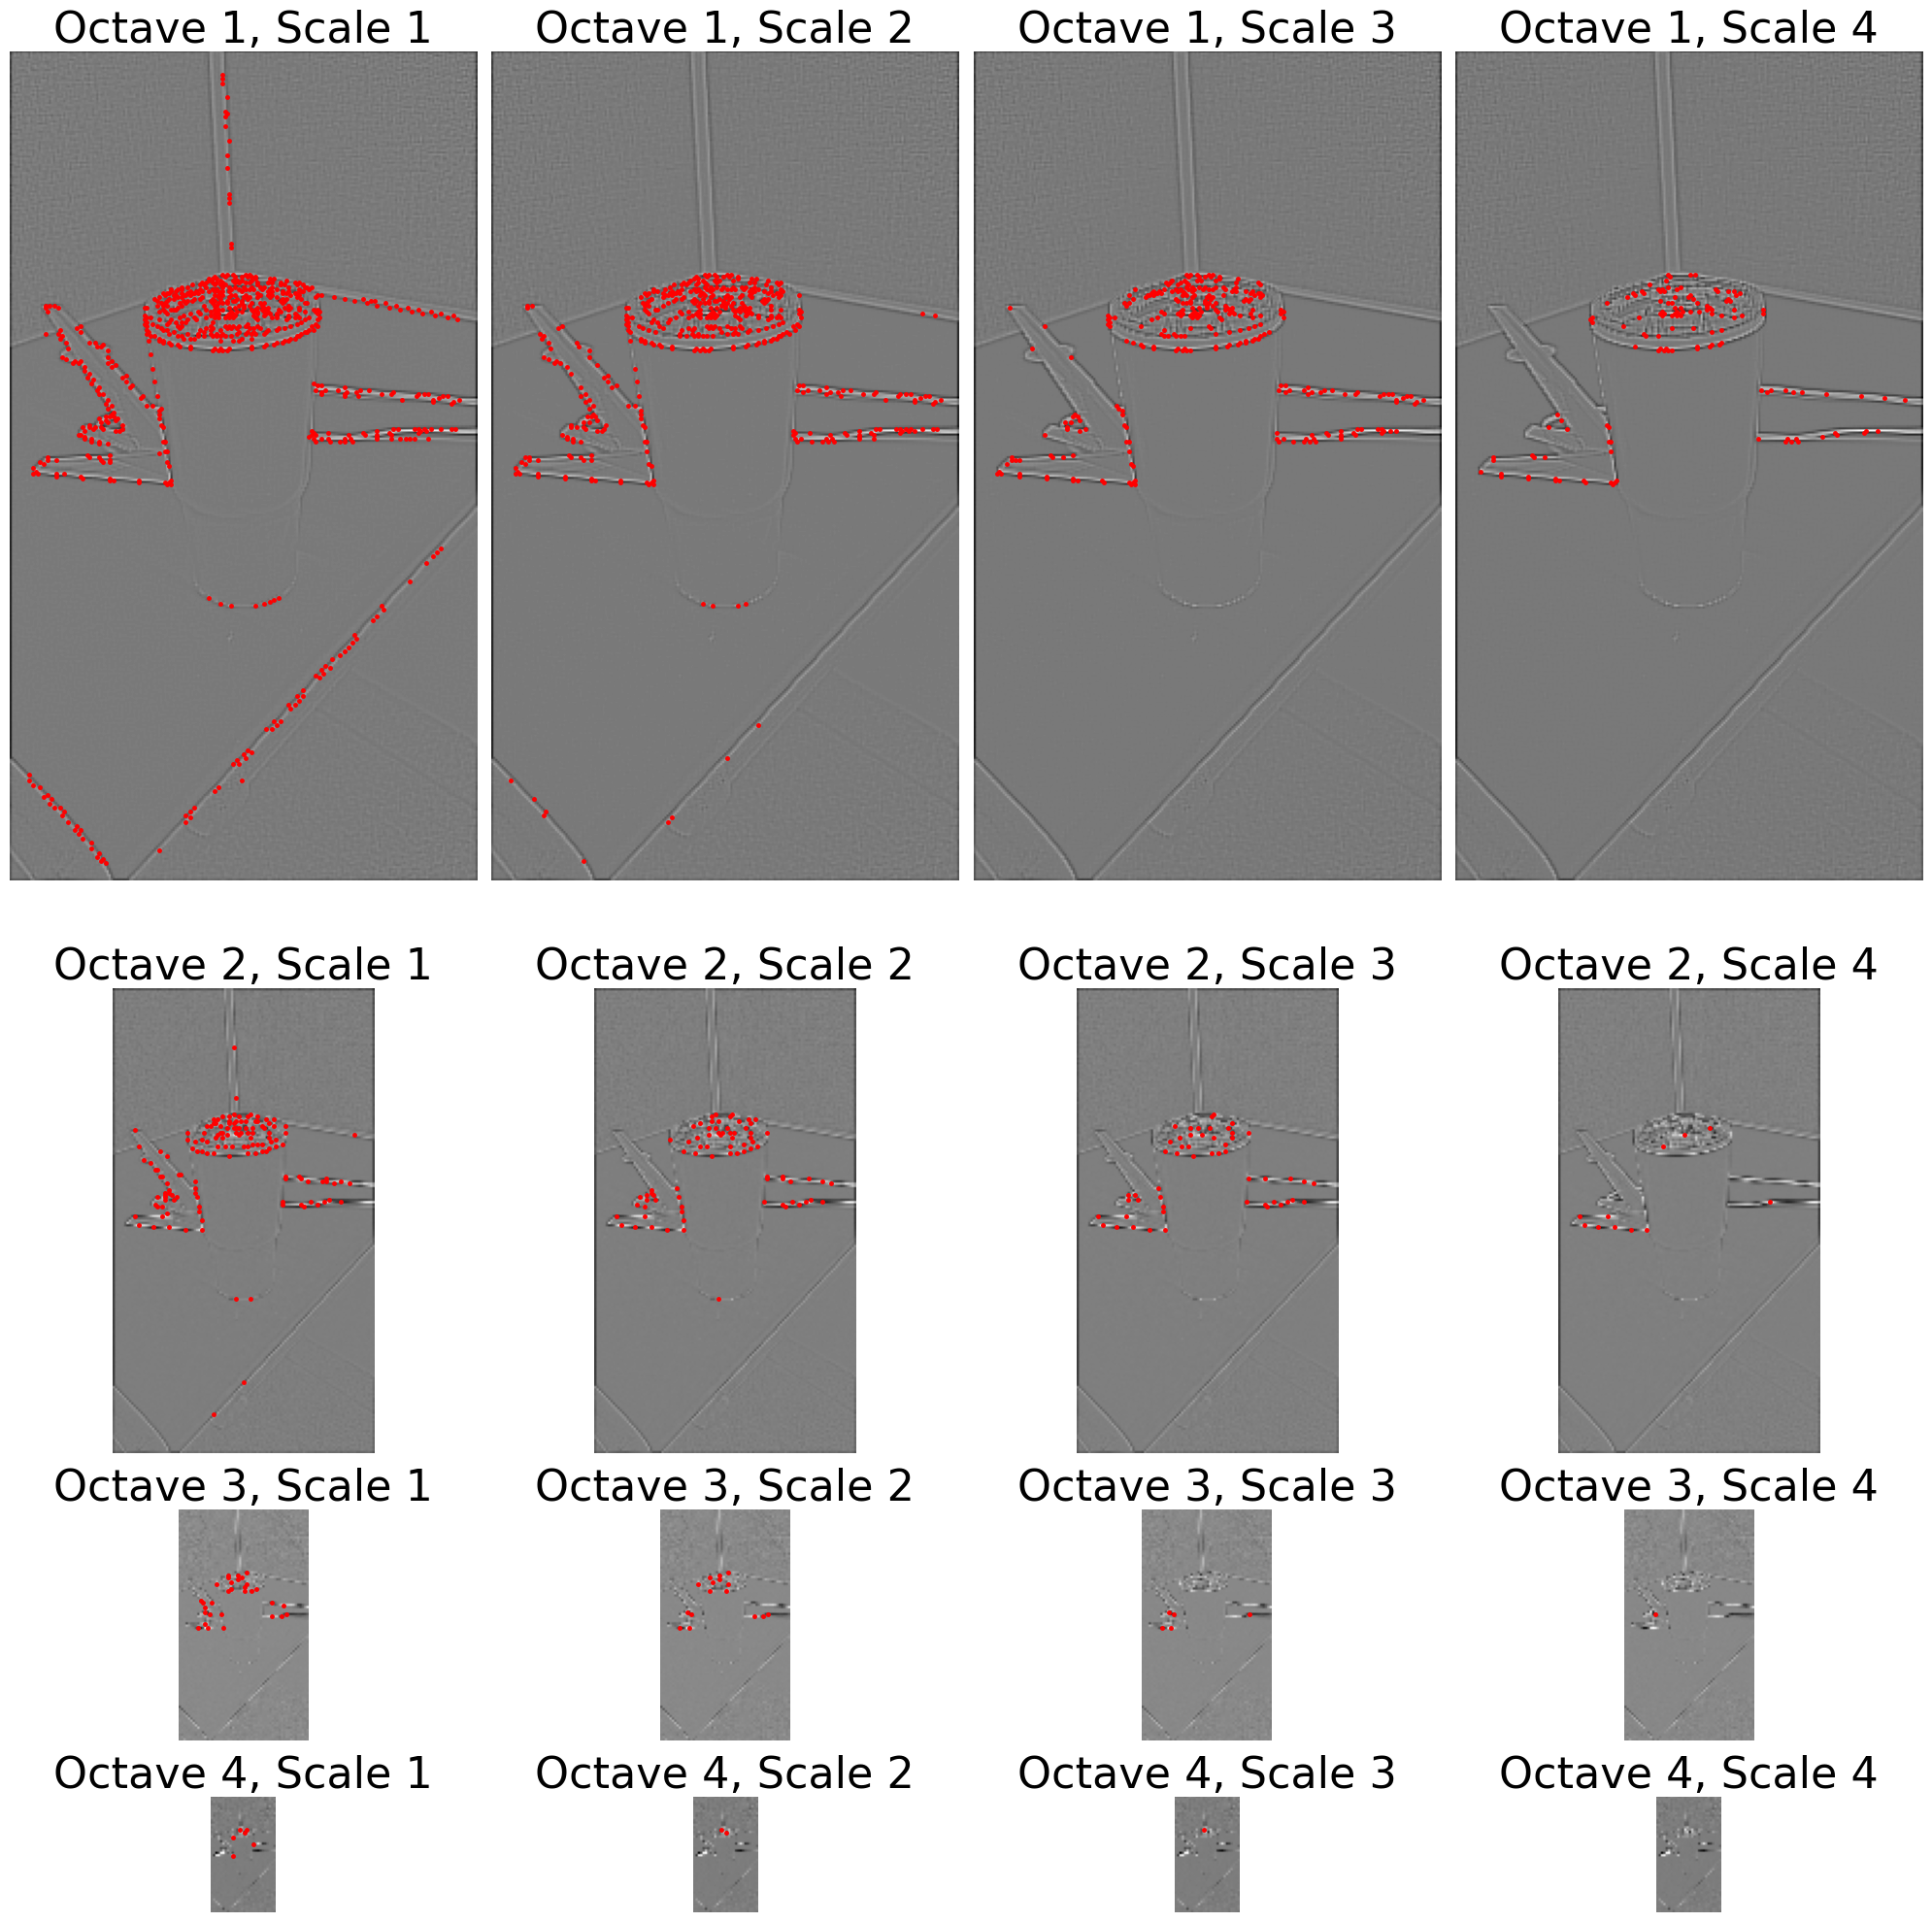

In [18]:
# 키 포인트와 함께 피라미드 시각화
visualize_keypoints(DoG, keypoints)


sobel filter  
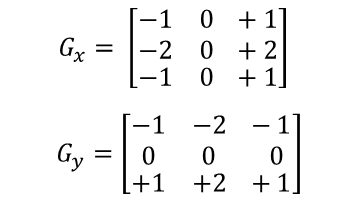

In [19]:
def show_sobel_filter(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gradient_x = convolve2d(image, kernel_x)
    gradient_y = convolve2d(image, kernel_y)
    
    plt.subplot(1,2,1)
    plt.imshow(gradient_x, cmap = "gray")
    plt.subplot(1,2,2)
    plt.imshow(gradient_y, cmap = "gray")
    plt.show()

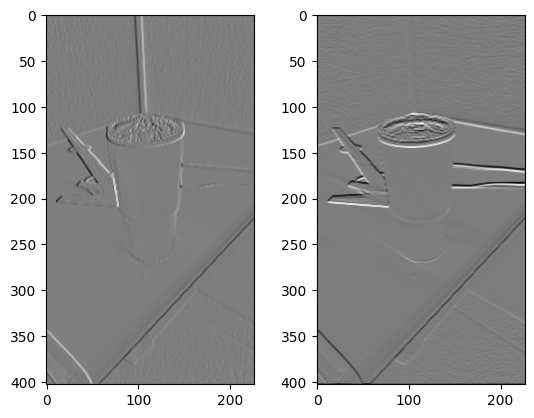

In [20]:
show_sobel_filter(image1)

In [21]:
def compute_gradients(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gradient_x = convolve2d(image, kernel_x)
    gradient_y = convolve2d(image, kernel_y)
    
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    orientation = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
    orientation[orientation < 0] += 360
    
    return magnitude, orientation

def assign_orientations(keypoints, pyramids):
    gradients = {}
    for o in range(len(pyramids)):
        gradients[o] = [compute_gradients(scale) for scale in pyramids[o]]
        
    for i, keypoint in enumerate(keypoints):
        y, x, o, s = keypoint
        magnitude, orientation = gradients[o][s]
        
        hist, bins = np.histogram(orientation[max(y-8,0):min(y+8,magnitude.shape[0]), 
                                              max(x-8,0):min(x+8,magnitude.shape[1])], 
                                   bins=36, range=(0, 360))
        max_bin = np.argmax(hist)
        
        keypoints[i] = {'position': (y, x), 'octave': o, 'scale': s, 'orientation': bins[max_bin], 'magnitude': hist[max_bin]}
    
    return keypoints
        
def compute_descriptors(keypoints, pyramids):
    gradients = {}
    for o in range(len(pyramids)):
        gradients[o] = [compute_gradients(scale) for scale in pyramids[o]]
    
    descriptors = []
    for keypoint in keypoints:
        y, x = keypoint['position']
        o, s = keypoint['octave'], keypoint['scale']
        magnitude, orientation = gradients[o][s]
        
        # Compute the descriptor
        descriptor = []
        for dx in range(max(y-8,0), min(y+8,magnitude.shape[0]), 4):
            for dy in range(max(x-8,0), min(x+8,magnitude.shape[1]), 4):
                hist, bins = np.histogram(orientation[dx:dx+4, dy:dy+4], bins=8, range=(0, 360))
                descriptor.extend(hist)
        
        # Normalize the descriptor
        descriptor = np.array(descriptor)
        descriptor = descriptor / np.sqrt(np.sum(descriptor**2))
        descriptors.append(descriptor)
    
    return descriptors


In [22]:
import time

def sift_algorithm(image, num_octaves=4, num_scales=5, sigma=1, kernel_size=3):
    start_time = time.time()
    
    # Step 1: Scale-space Extrema Detection
    pyramids_start_time = time.time()
    pyramids = build_gaussian_pyramid(image, num_octaves, num_scales, sigma, kernel_size)
    print(f"Scale-space Extrema Detection time: {time.time() - pyramids_start_time:.4f} seconds")
    
    # Step 2: Keypoint Localization
    keypoints_start_time = time.time()
    DoGs = compute_DoG(pyramids)
    keypoints = find_keypoints(DoGs)
    print(f"Keypoint Localization time: {time.time() - keypoints_start_time:.4f} seconds")
    
    # Step 3: Orientation Assignment
    orientations_start_time = time.time()
    keypoints_with_orientations = assign_orientations(keypoints, pyramids)
    print(f"Orientation Assignment time: {time.time() - orientations_start_time:.4f} seconds")
    
    # Step 4: Keypoint Descriptor
    descriptors_start_time = time.time()
    descriptors = compute_descriptors(keypoints_with_orientations, pyramids)
    print(f"Keypoint Descriptor time: {time.time() - descriptors_start_time:.4f} seconds")
    
    print(f"Total time: {time.time() - start_time:.4f} seconds")
    
    return keypoints_with_orientations, descriptors



In [23]:
def visualize_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    for keypoint in keypoints:
        y, x = keypoint['position']
        octave = keypoint['octave']
        scale_factor = 2 ** octave
        x *= scale_factor
        y *= scale_factor
        plt.plot(x, y, 'r.', markersize=5)
        orientation = keypoint.get('orientation', 0)
        magnitude = keypoint.get('magnitude', 5)
        dx = magnitude * np.cos(np.deg2rad(orientation)) * 0.5
        dy = magnitude * np.sin(np.deg2rad(orientation)) * 0.5
        plt.arrow(x, y, dx, dy, color='y', width=0.1)
    plt.show()


In [24]:
keypoints1, descriptors1 = sift_algorithm(image1)

Scale-space Extrema Detection time: 4.3649 seconds
Keypoint Localization time: 0.5501 seconds
Orientation Assignment time: 3.0302 seconds
Keypoint Descriptor time: 3.7646 seconds
Total time: 11.7110 seconds


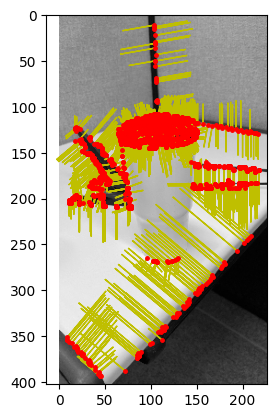

In [25]:
visualize_keypoints(image1, keypoints1)

In [26]:
def draw_descriptors(image, keypoints, descriptors):
    image_with_descriptors = image.copy()
    size_of_bin = 360 // 8  # 8개의 방향 빈이 있으므로

    for i, keypoint in enumerate(keypoints):
        y, x = keypoint['position']
        octave = keypoint['octave']
        descriptor = descriptors[i].reshape(4, 4, 8)  # 4x4 그리드와 8개의 방향 빈으로 재구성

        for dx in range(4):
            for dy in range(4):
                for bin_num in range(8):
                    magnitude = descriptor[dx, dy, bin_num]

                    if magnitude > 0:  # 값이 있는 빈만 그립니다
                        angle = bin_num * size_of_bin
                        end_point = (
                            int((x + dx * 4) * (2 ** octave) + magnitude * 20 * np.cos(np.deg2rad(angle))),
                            int((y + dy * 4) * (2 ** octave) - magnitude * 20 * np.sin(np.deg2rad(angle)))
                        )
                        cv2.line(image_with_descriptors, (x * (2 ** octave), y * (2 ** octave)), end_point, (0, 255, 0), 1)

    return image_with_descriptors

In [27]:
def draw_single_descriptor(image, keypoint, descriptor):
    image_with_descriptor = image.copy()
    size_of_bin = 360 // 8  # 8개의 방향 빈이 있으므로
    y, x = keypoint['position']
    octave = keypoint['octave']
    descriptor = descriptor.reshape(4, 4, 8)  # 4x4 그리드와 8개의 방향 빈으로 재구성

    for dx in range(4):
        for dy in range(4):
            for bin_num in range(8):
                magnitude = descriptor[dx, dy, bin_num]

                if magnitude > 0:  # 값이 있는 빈만 그립니다
                    angle = bin_num * size_of_bin
                    """end_point = (
                        int((x + dx * 4) * (2 ** octave) + magnitude * 20 * np.cos(np.deg2rad(angle))),
                        int((y + dy * 4) * (2 ** octave) - magnitude * 20 * np.sin(np.deg2rad(angle)))
                    )
                    cv2.line(image_with_descriptor, (x * (2 ** octave), y * (2 ** octave)), end_point, (0, 255, 0), 1)"""
                    end_point = (
                        int((x + dx * 4 + 2) * (2 ** octave) + magnitude * 20 * np.cos(np.deg2rad(angle))),
                        int((y + dy * 4 + 2) * (2 ** octave) - magnitude * 20 * np.sin(np.deg2rad(angle)))
                    )
                    cv2.line(image_with_descriptor, ((x + dx * 4 + 2) * (2 ** octave), (y + dy * 4 + 2) * (2 ** octave)), end_point, (0, 255, 0), 1)

    return image_with_descriptor


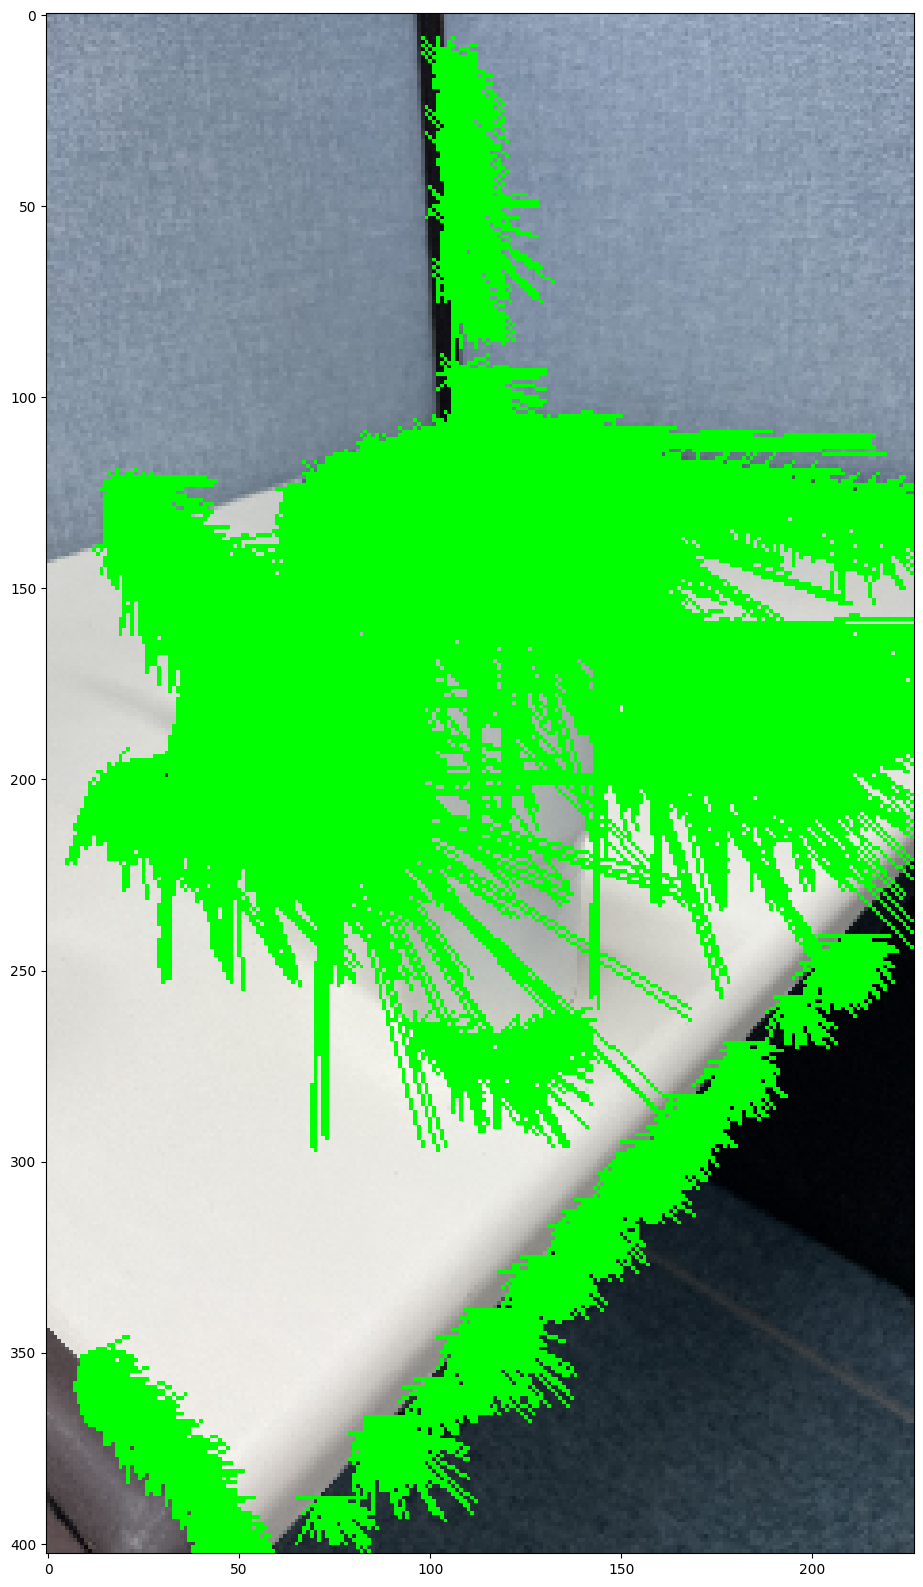

In [28]:
image1 = cv2.imread("./sample1.jpg")
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image1 = cv2.resize(image1, dsize=(0,0), fx=0.1, fy=0.1)

plt.figure(figsize=(20,20))
plt.imshow(draw_descriptors(image1, keypoints1, descriptors1))
plt.show()

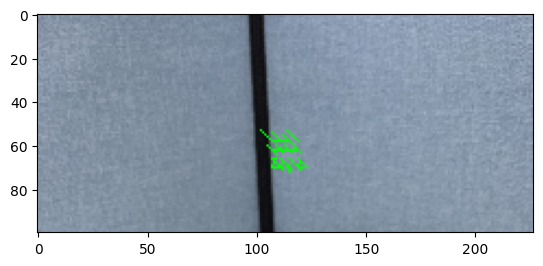

In [29]:
plt.figure()
plt.imshow(draw_single_descriptor(image1[:100], keypoints1[10], descriptors1[10]))
plt.show()

In [30]:
image1[:200,:200].shape

(200, 200, 3)

In [31]:
keypoints1[0]

{'position': (11, 103),
 'octave': 0,
 'scale': 0,
 'orientation': 170.0,
 'magnitude': 68}

In [32]:
print(len(descriptors1))
print(len(descriptors1[0]))
print(np.array(descriptors1).shape)

2027
128
(2027, 128)


In [33]:
print(len(keypoints1))
print(len(descriptors1))

2027
2027


In [34]:
descriptors1[0].reshape(4, 4, 8)

array([[[0.        , 0.        , 0.        , 0.29078454, 0.04154065,
         0.        , 0.        , 0.        ],
        [0.02077032, 0.        , 0.        , 0.04154065, 0.0830813 ,
         0.        , 0.02077032, 0.1661626 ],
        [0.20770325, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.12462195],
        [0.12462195, 0.18693292, 0.02077032, 0.        , 0.        ,
         0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.31155487, 0.02077032,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.14539227, 0.06231097,
         0.02077032, 0.02077032, 0.0830813 ],
        [0.02077032, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.31155487],
        [0.0830813 , 0.02077032, 0.        , 0.        , 0.        ,
         0.04154065, 0.0830813 , 0.10385162]],

       [[0.        , 0.        , 0.        , 0.33232519, 0.        ,
       

In [42]:
from sklearn.metrics.pairwise import euclidean_distances

def match_descriptors(descriptors1, descriptors2, threshold=0.5):
    distances = euclidean_distances(descriptors1, descriptors2)
    matches = []
    for i in range(distances.shape[0]):
        min_distance_idx = np.argmin(distances[i])
        if distances[i, min_distance_idx] < threshold and np.argmin(distances[:, min_distance_idx]) == i:
            matches.append(min_distance_idx)
        else:
            matches.append(-1)  # 의미 없는 매치를 표시하기 위한 -1

    return matches


def draw_matches(image1, image2, keypoints1, keypoints2, matches):
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    output_image = np.zeros((max(h1, h2), w1 + w2), dtype='uint8')
    output_image[:h1, :w1] = image1
    output_image[:h2, w1:w1+w2] = image2

    for i, match in enumerate(matches):
        if match == -1:
            continue
        y1, x1 = keypoints1[i]['position']
        y2, x2 = keypoints2[match]['position']
        octave1 = keypoints1[i]['octave']
        octave2 = keypoints2[match]['octave']
        
        x1, y1 = x1 * (2 ** octave1), y1 * (2 ** octave1)
        x2, y2 = x2 * (2 ** octave2), y2 * (2 ** octave2)
        print(x1,y1,x2,y2)
        color = 255  # 흰색 선을 사용합니다
        cv2.line(output_image, (x1, y1), (x2 + w1, y2), color, 1)

    plt.imshow(output_image, cmap='gray')
    plt.axis('off')
    plt.show()



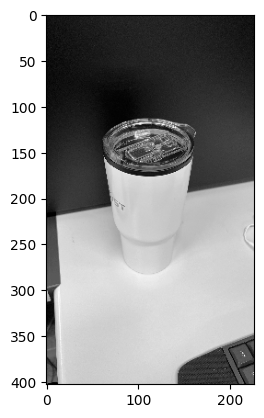

In [43]:
image2 = cv2.imread("./sample2.jpg", cv2.IMREAD_GRAYSCALE)
image2 = cv2.resize(image2, dsize=(0,0), fx=0.1, fy=0.1)
image2 = np.float32(image2)

plt.imshow(image2, cmap='gray')
plt.show()

Scale-space Extrema Detection time: 4.3907 seconds
Keypoint Localization time: 0.5497 seconds
Orientation Assignment time: 3.1037 seconds
Keypoint Descriptor time: 4.0362 seconds
Total time: 12.0813 seconds


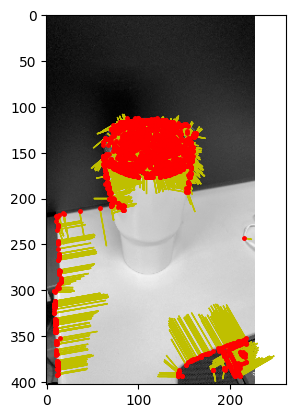

In [44]:
keypoints2, descriptors2 = sift_algorithm(image2)
visualize_keypoints(image2, keypoints2)

In [45]:
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

error: OpenCV(4.8.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xa7e5ea26::Set<1,-1,-1>,struct cv::impl::A0xa7e5ea26::Set<0,2,5>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [46]:
image1.shape

(403, 227)

In [47]:
image2.shape

(403, 227)

107 95 65 175
83 123 82 131
123 143 129 175
160 293 144 389
148 303 155 177
124 142 125 175


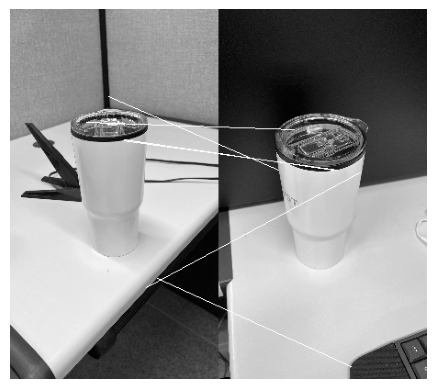

In [48]:
match = match_descriptors(descriptors1, descriptors2, threshold=0.5)
draw_matches(image1, image2, keypoints1, keypoints2, match)

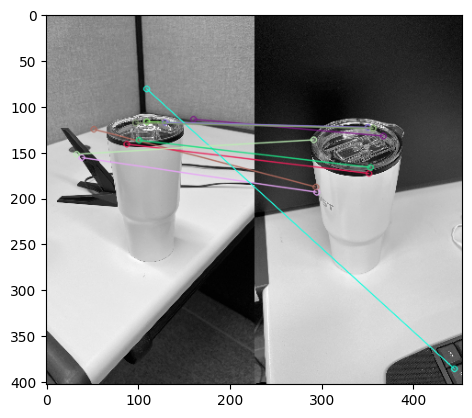

In [49]:
# 이미지 불러오기
image1 = cv2.imread('sample1.jpg', 0)  # 0 플래그는 흑백 이미지로 불러옵니다
image2 = cv2.imread('sample2.jpg', 0)

image1 = cv2.resize(image1, dsize=(0,0), fx=0.1, fy=0.1)
image2 = cv2.resize(image2, dsize=(0,0), fx=0.1, fy=0.1)

# SIFT 디텍터 생성
sift = cv2.SIFT_create()

# 각 이미지에서 키포인트와 디스크립터 찾기
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# BFMatcher 객체 생성
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# 디스크립터 매칭
matches = bf.match(descriptors1, descriptors2)

# 매칭 결과를 거리에 따라 정렬
matches = sorted(matches, key = lambda x:x.distance)

# 매칭 결과 시각화
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.show()
